# *svoboda lab / tactile navigation*

This notebook loads and plots the summary imaging data found in SofroniewVlasov2015

## Setup evnironment

In [2]:
import os
import numpy as np
import pandas as pd
import json

## Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from helper.plots import *

## Helper functions for loading and processing data

This helper function is using during loading to align tables to a primary key

In [4]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index,inplace = True)
    table.columns = table.columns.astype('float')
    return table

This helper function loads mutliple tables from a session into a dictionary where the keys are table names

In [5]:
def load(session):
    # load the info
    with open(os.path.join(path,'data',session,'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # load the units (which have our primary keys)
    d['units'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','units.csv'))
    d['units']['sourceId'] = d['units'].index
    
    # load all the tables    
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarizeTuning(d['tuning'])
  
    d['units'] = d['units'].drop(['sourceId'], axis=1)
    
    # add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    #d['info'] = info
    return d, info

#### Append position tuning information to units data frame

In [6]:
def summarizeTuning(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0],smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    return summary

#### Define smooth parameter

In [7]:
smooth = 1

## Load JSON + CSV as DataFrames

#### Specify location of the data

In [8]:
path = os.path.expanduser('~/notebooks')

#### Load the tables from each session

In [31]:
sessions = range(13,19)
data = [load('%02g' % s) for s in sessions]
table =  pd.concat([x[0] for x in data], keys=[str(x[1].index[0]) for x in data], names=['anmId'])
info =  pd.concat([x[1] for x in data])

## Summarize units

#### Summarize units

In [32]:
units = table.units.reset_index()
unitCount = units.groupby(['anmId']).count()['sourceId'].values
units.set_index(['anmId', 'sourceId'], inplace=True)
unitSummary = pd.Series({'total':len(units), 'mean':np.mean(unitCount), 'std':np.std(unitCount), 'numAnm':len(unitCount)})
unitSummary

mean       336.500000
numAnm       6.000000
std         69.875484
total     2019.000000
dtype: float64

#### Plot fractions of active and tuned neurons

In [33]:
tuned = (units.pVal<0.05) & (table.tuningSummary.Range > .3)
active = units.activity > 1.0
summaryActivity = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], index=['inactive','tuned','untuned'], columns=['number'])
summaryActivity['percent'] = 100*summaryActivity.number/summaryActivity.number.sum()
summaryActivity

,number,percent
inactive,1121,55.522536
tuned,564,27.934621
untuned,334,16.542843


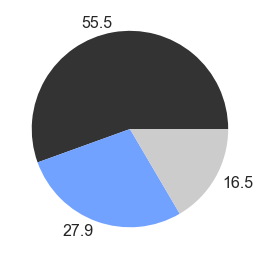

In [34]:
col = colormap()(0)[:3]
plt.axes(aspect=1);
plt.pie(summaryActivity.percent, labels=['%.1f' % summaryActivity.percent.iloc[0],'%.1f' % summaryActivity.percent.iloc[1],'%.1f' % summaryActivity.percent.iloc[2]], colors=[[.2, .2, .2],col,[.8, .8, .8]], wedgeprops={'linewidth':0});
if savefig:
    plt.savefig(os.path.join(path,'figuresImaging','Percentages.eps'))

# Plot tuning curves

The paper includes the following tuning curves
* 'Anm_0216166', 150
* 'Anm_0216166', 160
* 'Anm_0216166', 159

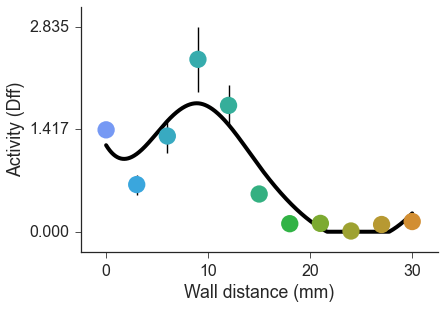

In [38]:
a = 'Anm_0216166'
u = 160
x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Activity (Dff)');

## Keep significantly tuned units

In [39]:
table = table[tuned.values]

## Plot summary tuning curves

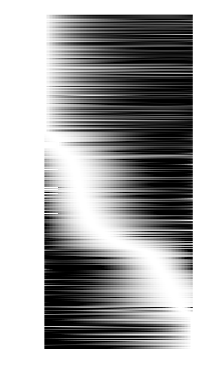

In [40]:
curves = table.sort([('tuningSummary','ArgMax')])
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=smooth, res=100)
heatmap(fits, aspect=.4)

## Plot summary tuning

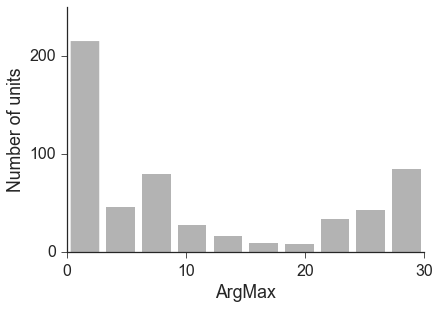

In [41]:
hist(table.tuningSummary.ArgMax, xlabel='ArgMax', ylabel='Number of units')
plt.xticks(range(0,40,10));
plt.yticks(range(0,300,100));